<a href="https://colab.research.google.com/github/natrask/ENM5310/blob/main/Graph_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#!/usr/bin/env python
# coding: utf-8
# In[91]:
import numpy as np
import scipy
import scipy.sparse
import scipy.sparse.linalg
import matplotlib.pyplot as plt
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
tf.reset_default_graph()
config = tf.ConfigProto()
sess = tf.Session(config=config)

Instructions for updating:
non-resource variables are not supported in the long term


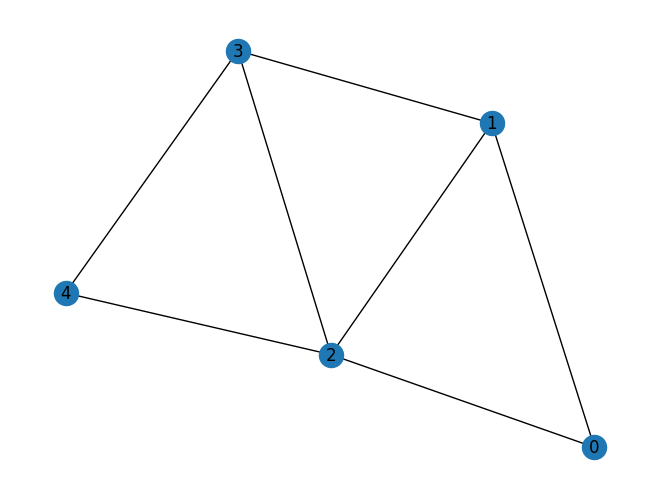

In [41]:
Nnodes = 5
dataList = []
rowcolList = []
edgeList = []
cnt=0
for i in range(Nnodes):
    for j in range(Nnodes):
#        if (j > i): #Don't double count entries
        if (j > i) & (abs(i-j)<3): #Don't double count entries and only connect nearby nodes
            dataList.append(-1)
            rowcolList.append([cnt,j])
            dataList.append(1)
            rowcolList.append([cnt,i])
            edgeList.append((i,j))
            cnt += 1
Nedges = cnt
#Recast as matrices
data = np.array(dataList)
rowcols = np.array(rowcolList)
delta = scipy.sparse.csr_matrix((data,(rowcols[:,0],rowcols[:,1])))
graphLap = delta.T*delta

#Visualize graph
import networkx as nx
G = nx.from_edgelist(edgeList)
nx.draw(G,with_labels=True)

In [105]:
#lets check some of the properties we've discussed in class about these operators
print('Columns of first row of graph gradient')
print(delta[0,:])
print('Columns of first row of graph divergence')
print(delta.T[0,:])
print('Columns of first row of graph divergence')
print(graphLap[0,:])
print('Eigenvalues of graph Laplacian -> symmetric positive semi-definite')
print(np.linalg.eig(graphLap.todense())[0])

Columns of first row of graph gradient
  (0, 0)	1
  (0, 1)	-1
Columns of first row of graph divergence
  (0, 0)	1
  (0, 1)	1
Columns of first row of graph divergence
  (0, 0)	2
  (0, 1)	-1
  (0, 2)	-1
Eigenvalues of graph Laplacian -> symmetric positive semi-definite
[0.         1.58578644 3.         5.         4.41421356]


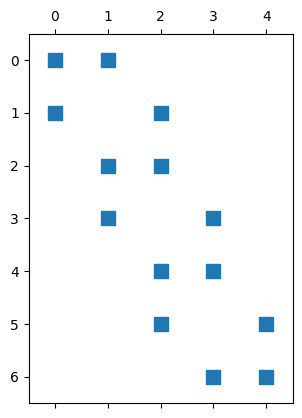

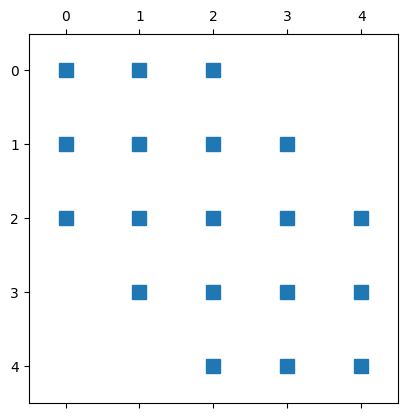

In [40]:
#Plot sparsity patterns of graph derivatives
plt.figure()
plt.spy(delta)
plt.figure()
plt.spy(graphLap)

**Example 1: Data-driven circuit model using graphs**

We will solve the steady state equations for a given forcing $f$ and solve for an unknown resistance $R$ to obtain voltages and currents as close as possible to a dataset

$$\mathcal{L} = ||V - V_{target}||^2 + \epsilon ||J - J_{target}||^2$$

In [66]:
Ndata = 10

f_in = tf.placeholder(shape=(Ndata,Nnodes),dtype=tf.float64)
V_in = tf.placeholder(shape=(Ndata,Nnodes),dtype=tf.float64)
J_in = tf.placeholder(shape=(Ndata,Nedges),dtype=tf.float64)
logR_var = tf.Variable(np.zeros(Nedges),dtype=tf.float64)
R_var = tf.exp(logR_var)

KVL_mat = tf.einsum('ie,e,ej->ij',(delta.T).todense(),R_var,delta.todense())
KVL_rhs = f_in  - tf.expand_dims(tf.reduce_mean(f_in,axis=-1),-1)
V_sol = tf.linalg.solve(KVL_mat,tf.transpose(KVL_rhs))  #note that forcing must have zero mean for solution to exist
J_sol = tf.einsum('e,en,nd->ed',R_var,delta.todense(),V_sol)

#Build loss function
epsilon = 1.0
LOSS_voltage = tf.reduce_mean( (V_in - tf.transpose(V_sol))**2 )
LOSS_current = tf.reduce_mean( (J_in - tf.transpose(J_sol))**2 )
LOSS_circuit = LOSS_voltage + epsilon*LOSS_current

**Example 2: Message passing graph attention network**
A similarly structured code will allow us to implement a single layer of a graph attention network. Note that the graph attention mechanism plays a similar role to the resistance in the resistor network example.

We compute *messages*:
$$m_{ij} = \mathcal{NN}_1(x_i-x_j)$$
As well as *preattention*:
$$a_{ij} = \mathcal{NN}_2(x_i,x_j)$$
Which we combinate via attention
$$GAT_i = \sum_{j\sim i} \underset{j}{\text{softmax}}(a_{ij})\, m_{ij}$$

Note that there are many options for attention mechanisms as we discussed in class - here we're showing a varient of multi-head self-attention which will learn to attend to different messages

In [202]:
Ndata = 10

x_in = tf.placeholder(shape=(Ndata,Nnodes),dtype=tf.float64)

# Build message passing network. We follow the general setup from GRAND (https://arxiv.org/pdf/2106.10934.pdf)
NNhidden0_u = tf.layers.Dense(10,activation='tanh')
NNhidden1_u = tf.layers.Dense(10,activation='tanh')
NNlinear_u  = tf.layers.Dense(1,activation='linear')
def messageNN(x):
  return NNlinear_u(NNhidden1_u(NNhidden0_u(x)))

gradx = tf.einsum('en,dn->ed',delta.todense(),x_in)

#this is not a smart way to do this - all libraries have a "map" function to apply dnns componentwise
#this is a way to do everything using basic python
messageList = [messageNN(tf.expand_dims(gradx[:,j],-1)) for j in range(Ndata)]
messages = tf.concat(messageList,axis=1) # NedgesxNdata

#build attention mechanism network
NNhidden0_a = tf.layers.Dense(10,activation='tanh')
NNhidden1_a = tf.layers.Dense(10,activation='tanh')
NNlinear_a  = tf.layers.Dense(1,activation='linear')
def attnNN(x):
  return NNlinear_a(NNhidden1_a(NNhidden0_a(x)))

DT = np.array((delta.todense()).T)

GAToutput_list = []
for i in range(Nnodes):
  neighbors_of_i = np.where(DT[i,:] != 0)[0]
  preattentionList = []
  for edgeij in neighbors_of_i:
    edgeij_indices = np.where(DT.T[edgeij]!=0)[0]
    eij = attnNN(tf.stack((x_in[:,edgeij_indices[0]],x_in[:,edgeij_indices[1]]),axis=-1))
    preattentionList.append(eij)
  aij = tf.nn.softmax(tf.stack(preattentionList,axis=1),axis=1)
  aggregateList = []
  index = 0
  output_nodei = 0
  for edgeij in neighbors_of_i:
    output_nodei += aij[:,index,0]*messages[edgeij,:]
  GAToutput_list.append(output_nodei)
GAToutput = tf.stack(GAToutput_list,axis=1)



In [201]:
GAToutput

<tf.Tensor 'stack_324:0' shape=(10, 5) dtype=float64>